In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import scipy
from sklearn.linear_model import LinearRegression

In [99]:
np.random.seed(42)

epsilon = 3
n_periods = 100
n_units = 10
effect_size = 10
time_effect = 0.4
treatment_start = 50

treated_unit = 5

time = np.arange(n_periods)
units = np.arange(n_units)

data = []

for unit in units:
    base = np.sin(0.1 * time) + time_effect*time + unit + np.random.normal(loc=0, scale=epsilon, size=n_periods) # '+ unit' is just to make them different
    effect = effect_size * (time > treatment_start) if unit == treated_unit else 0 # treatment starts at t=50 for treated_unit and has an effect size of effect_size
    y_obs_unit = base + effect
    data.append(y_obs_unit)

df = pd.DataFrame(data).T
df.columns = [f'unit_{i}' for i in units]
df['time'] = time
df.set_index('time', inplace=True)

df.head(5)

,unit_0,unit_1,unit_2,unit_3,unit_4,unit_5,unit_6,unit_7,unit_8,unit_9
time,,,,,,,,,,
0,1.490142,-3.246112,3.073362,0.513015,-0.783283,7.778533,8.270966,5.431831,10.814851,10.106020
1,0.085041,0.237897,4.182187,1.819290,2.701708,11.228083,3.733337,10.646861,6.951699,8.319817
2,2.941735,0.970526,6.247823,6.240550,5.014400,1.802967,9.607487,5.885638,9.287032,10.084904
3,6.064610,0.088688,6.656926,6.326631,5.636462,8.184428,11.562434,4.270136,8.108694,14.330876
4,1.286958,2.505561,-0.143590,4.926714,4.639222,5.037491,9.229723,4.319531,8.685930,11.562716


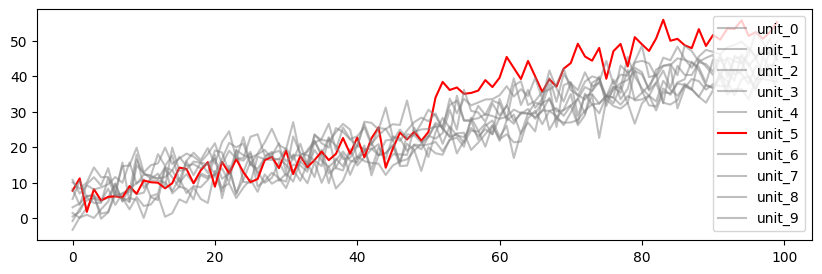

In [100]:
fig, ax = plt.subplots(figsize=(10, 3))
for unit in df.columns:
    color = 'red' if unit == f'unit_{treated_unit}' else 'gray'
    alpha = 1 if unit == f'unit_{treated_unit}' else 0.5
    ax.plot(df.index, df[unit], color=color, alpha=alpha, label=unit)
ax.legend()
plt.show()

In [162]:
X_pre = df.loc[df.index < treatment_start, df.columns.difference([f'unit_{treated_unit}'])]
y_pre = df.loc[df.index < treatment_start, f'unit_{treated_unit}']

# find optimal weights
reg = LinearRegression(fit_intercept=False)
reg.fit(X_pre, y_pre)

def check_regression_assumptions(model, X, y):
    
    residuals = y - model.predict(X)

    # Jarque-Bera test (normality of residuals via skewnesss and kurtosis)
    jb_stat, jb_p, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
    print(f"Jarque-Bera test (normality): stat={jb_stat:.3f}, p-value={jb_p:.3f}")

    # Shapiro-Wilk test (normality)
    shapiro_stat, shapiro_p = statsmodels.stats.diagnostic.kstest_normal(residuals)
    print(f"Shapiro-Wilk test (normality): stat={shapiro_stat:.3f}, p-value={shapiro_p:.3f}")

    # Ljung-Box test (autocorrelation in residuals at multiple lags)
    ljung_box_results = statsmodels.stats.diagnostic.acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(f'Ljung-Box test (residual autocorr.): stat={ljung_box_results.lb_stat.values[0]:.3f}, p-value={ljung_box_results.lb_pvalue.values[0]:.3f}' )

    # Breusch-Pagan test (homoskedasticity)
    residuals_sq = residuals ** 2
    aux_reg = LinearRegression(fit_intercept=True)
    aux_reg.fit(X, residuals_sq)
    r2 = aux_reg.score(X, residuals_sq)
    n = len(y)
    bp_stat = n*r2
    bp_p = scipy.stats.chi2.sf(bp_stat, df=X.shape[1])
    print(f"Breusch-Pagan test (homoskedasticity): stat={bp_stat:.3f}, p-value={bp_p:.3f}")


check_regression_assumptions(reg, X_pre, y_pre)

Jarque-Bera test (normality): stat=0.801, p-value=0.670
Shapiro-Wilk test (normality): stat=0.069, p-value=0.799
Ljung-Box test (residual autocorr.): stat=10.256, p-value=0.418
Breusch-Pagan test (homoskedasticity): stat=9.293, p-value=0.411


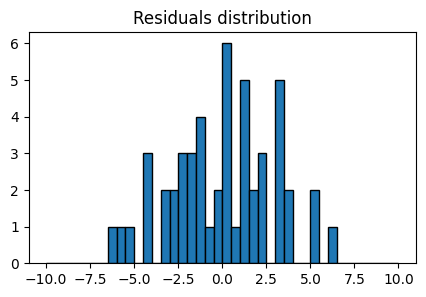

In [161]:
residuals = y_pre - reg.predict(X_pre)
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_title('Residuals distribution')
ax.hist(residuals, bins=np.arange(-10, 10.5, 0.5), edgecolor='black')
plt.show()

In [ ]:
# Construct the synthetic control
synthetic_control = df[df.columns.difference(['time', treated_unit])].dot(weights)

df.loc[pre_treatment_period, treated_unit].shape

#fig, ax = plt.subplots()
#ax.scatter(synthetic_control, df.loc[pre_treatment_period, treated_unit])
#plt.show()


(51,)

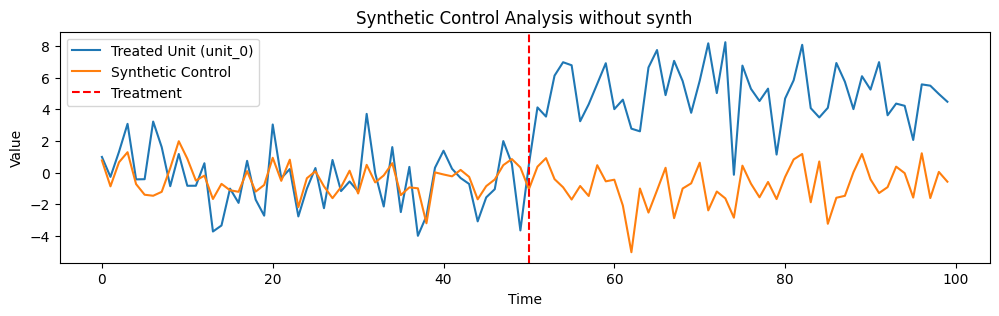

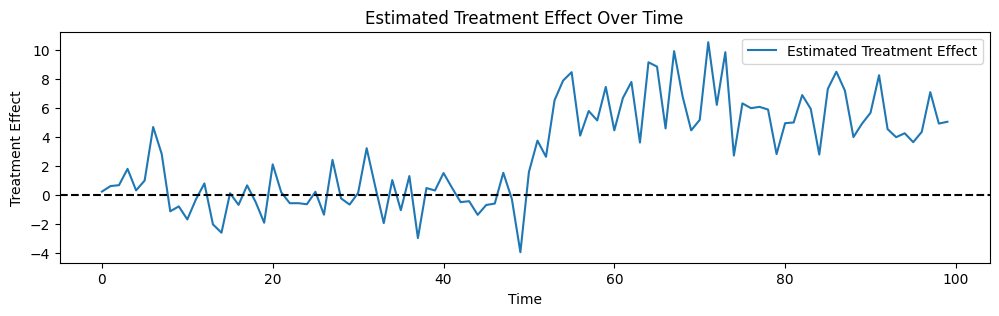

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 3))
plt.plot(df['time'], df[treated_unit], label='Treated Unit (unit_0)')
plt.plot(df['time'], synthetic_control, label='Synthetic Control')
plt.axvline(x=50, color='red', linestyle='--', label='Treatment')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Synthetic Control Analysis without synth')
plt.legend()
plt.show()

# Calculate the treatment effect
treatment_effect = df[treated_unit] - synthetic_control

# Plot the estimated treatment effect
plt.figure(figsize=(12, 3))
plt.plot(time, treatment_effect, label='Estimated Treatment Effect')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Treatment Effect')
plt.title('Estimated Treatment Effect Over Time')
plt.legend()
plt.show()


In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

regression_results(, y_pre)

SyntaxError: invalid syntax (1744315522.py, line 19)

In [ ]:
# Placeholder for placebo testing results
placebo_effects = []

for control_unit in df.columns.difference(['time', treated_unit]):
    # Prepare data for control unit as 'treated'
    y_pre_placebo = df.loc[pre_treatment_period, control_unit]
    reg.fit(X_pre, y_pre_placebo)
    weights_placebo = reg.coef_
    synthetic_control_placebo = df[df.columns.difference(['time', control_unit])].dot(weights_placebo)
    
    # Calculate placebo treatment effect
    placebo_treatment_effect = df[control_unit] - synthetic_control_placebo
    placebo_effects.append(placebo_treatment_effect)

# Calculate distribution of placebo effects
placebo_effects_df = pd.DataFrame(placebo_effects).T

# Plot the treatment effect against placebo effects
plt.figure(figsize=(12, 6))
plt.plot(df['time'], treatment_effect, label='Actual Treatment Effect', color='red')
for column in placebo_effects_df:
    plt.plot(df['time'], placebo_effects_df[column], color='grey', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Effect')
plt.title('Treatment Effect vs. Placebo Effects')
plt.legend()
plt.show()
